# Лабораторная работа 4. Векторные представления слов

* В лабораторной работе используются словари для тем `Культура` и `Экономика`, построенные в предыдущей лабораторной работе. Для удобства словари можно сохранить в файлы, например, формата `json`.
* В лабораторной работе следует продумать использование начальной формы слов и их словоформ. Заранее прочитайте задания, продумайте решения и поэкспериментируйте с кодом.

**Задание 1.** Напишите функцию подсчёта количества контекстных слов по заданному корпусу `D` для заданного списка слов `M` и заданого размера окна `2*N` (N слов слева и справа от слова).

Используя новостной корпус из предыдущей лабораторной работы и топ-k слов в начальной форме из двух ранее построенных словарей для тем `Культура` и `Экономика`, постройте диаграмму количества контекстных соседей у слов (соседей рассматривайте независимо от словоформы).

Используйте параметры:
- k=[10, 50, 100] (т.к. словаря два, то количество слов будет в два раза больше),
- N=[1, 2, 5, 10].

Сделайте выводы.

Загрузка данных...
Работаем с 4000 документами
Размер кэша лемм: 76097

Запуск оптимизированного эксперимента...
k=10
Построение тематических словарей...
  N=1... 5251
  N=2... 9427
  N=5... 18503
  N=10... 28157
k=50
Построение тематических словарей...
  N=1... 18404
  N=2... 29755
  N=5... 48087
  N=10... 61210
k=100
Построение тематических словарей...
  N=1... 23517
  N=2... 36475
  N=5... 55406
  N=10... 67054


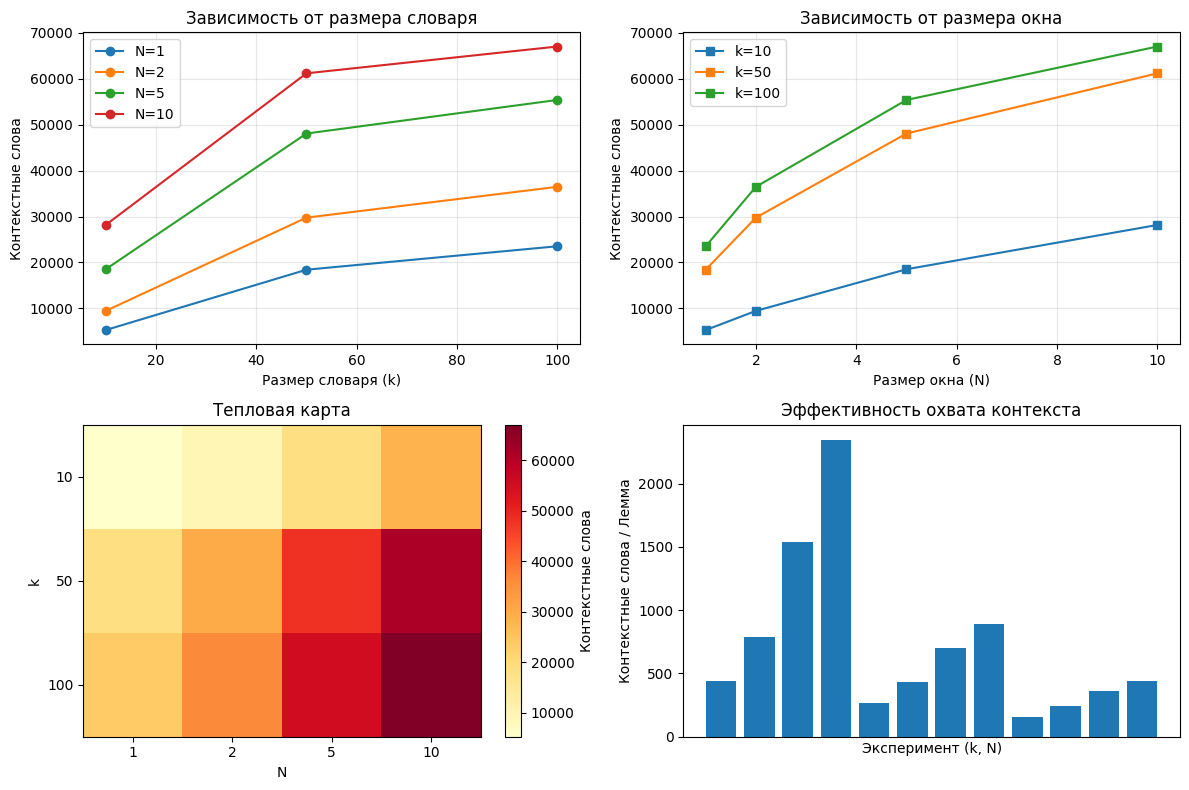

k	N	Леммы	Контекст
------------------------------
10	1	12	5251
10	2	12	9427
10	5	12	18503
10	10	12	28157
50	1	69	18404
50	2	69	29755
50	5	69	48087
50	10	69	61210
100	1	152	23517
100	2	152	36475
100	5	152	55406
100	10	152	67054
Максимальный охват: k=100, N=10 (67054 контекстных слов)

Демонстрация на ограниченном наборе частых слов...
Используем 46 самых частых слов
Контекстных слов для демо-набора: 64190


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import re
from natasha import (
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

def preprocess_corpus_fast(texts):
    lemma_cache = {}

    def get_lemma_cached(word):
        if word in lemma_cache:
            return lemma_cache[word]

        doc = Doc(word)
        doc.segment(segmenter)
        doc.tag_morph(morph_tagger)

        if doc.tokens:
            token = doc.tokens[0]
            token.lemmatize(morph_vocab)
            lemma = token.lemma.lower().strip()
            lemma_cache[word] = lemma
            return lemma
        return word.lower()

    processed_corpus = []
    for i, text in enumerate(texts):
        if not isinstance(text, str):
            processed_corpus.append(([], []))
            continue

        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\d+', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()

        tokens = [token for token in text.split() if len(token) > 2]
        lemmas = [get_lemma_cached(token) for token in tokens]
        processed_corpus.append((tokens, lemmas))

    print(f"Размер кэша лемм: {len(lemma_cache)}")
    return processed_corpus, lemma_cache

def build_topic_dictionaries_fast(df, top_k=100):
    print("Построение тематических словарей...")

    culture_df = df[df['topic'] == 'Культура']
    economy_df = df[df['topic'] == 'Экономика']

    # Быстрый сбор лемм
    culture_lemmas = []
    economy_lemmas = []

    for text in culture_df['text'].head(1000):  # Ограничиваем для скорости
        if isinstance(text, str):
            tokens = preprocess_text_fast(text)
            culture_lemmas.extend(tokens)

    for text in economy_df['text'].head(1000):
        if isinstance(text, str):
            tokens = preprocess_text_fast(text)
            economy_lemmas.extend(tokens)

    # Частотный анализ
    culture_freq = Counter(culture_lemmas)
    economy_freq = Counter(economy_lemmas)

    culture_top = [lemma for lemma, count in culture_freq.most_common(top_k)]
    economy_top = [lemma for lemma, count in economy_freq.most_common(top_k)]

    return culture_top, economy_top

def preprocess_text_fast(text):
    """Быстрая предобработка одного текста"""
    if not isinstance(text, str):
        return []

    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return [token for token in text.split() if len(token) > 2]

def count_context_words_optimized(corpus, target_lemmas, N):
    """
    Оптимизированный подсчет контекстных слов
    """
    context_words = set()
    target_set = set(target_lemmas)

    for tokens, lemmas in corpus:
        if not tokens:
            continue

        target_positions = []
        for i, lemma in enumerate(lemmas):
            if lemma in target_set:
                target_positions.append(i)

        # Для каждой целевой позиции собираем контекст
        for pos in target_positions:
            start = max(0, pos - N)
            end = min(len(tokens), pos + N + 1)

            # Быстрое добавление контекстных слов
            for j in range(start, end):
                if j != pos:  # Исключаем само целевое слово
                    context_word = tokens[j]
                    if len(context_word) > 2 and not context_word.isdigit():
                        context_words.add(context_word)

    return len(context_words)

# Основная программа
print("Загрузка данных...")
df = pd.read_csv('../../labs/lenta_ru_news_filtered.csv')

# Ограничиваем размер данных для скорости
sample_size = min(5000, len(df))
df = df.sample(sample_size, random_state=42)

print(f"Работаем с {len(df)} документами")

# Быстрая предобработка корпуса
corpus_data, lemma_cache = preprocess_corpus_fast(df['text'].tolist())

# Параметры эксперимента
k_values = [10, 50, 100]
N_values = [1, 2, 5, 10]

# Стоп-слова
stop_words = {'это', 'что', 'как', 'для', 'или', 'но', 'если', 'по', 'на', 'с', 'в'}

# Результаты
results = []

print("\nЗапуск оптимизированного эксперимента...")
for k in k_values:
    print(f"k={k}")

    # Быстрое построение словарей
    culture_dict, economy_dict = build_topic_dictionaries_fast(df, top_k=k)

    # Объединяем и фильтруем словари
    combined_lemmas = [lemma for lemma in set(culture_dict + economy_dict) if lemma not in stop_words]

    for N in N_values:
        print(f"  N={N}...", end=" ")

        context_count = count_context_words_optimized(corpus_data, combined_lemmas, N)

        results.append({
            'k': k,
            'N': N,
            'total_lemmas': len(combined_lemmas),
            'context_count': context_count
        })

        print(f"{context_count}")

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
for N in N_values:
    data = [r for r in results if r['N'] == N]
    k_vals = [r['k'] for r in data]
    context_vals = [r['context_count'] for r in data]
    plt.plot(k_vals, context_vals, marker='o', label=f'N={N}')

plt.xlabel('Размер словаря (k)')
plt.ylabel('Контекстные слова')
plt.title('Зависимость от размера словаря')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
for k in k_values:
    data = [r for r in results if r['k'] == k]
    N_vals = [r['N'] for r in data]
    context_vals = [r['context_count'] for r in data]
    plt.plot(N_vals, context_vals, marker='s', label=f'k={k}')

plt.xlabel('Размер окна (N)')
plt.ylabel('Контекстные слова')
plt.title('Зависимость от размера окна')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
pivot_data = pd.DataFrame(results).pivot(index='k', columns='N', values='context_count')
plt.imshow(pivot_data.values, cmap='YlOrRd', aspect='auto')
plt.colorbar(label='Контекстные слова')
plt.xticks(range(len(N_values)), N_values)
plt.yticks(range(len(k_values)), k_values)
plt.xlabel('N')
plt.ylabel('k')
plt.title('Тепловая карта')

plt.subplot(2, 2, 4)
efficiency_data = []
for result in results:
    efficiency = result['context_count'] / result['total_lemmas'] if result['total_lemmas'] > 0 else 0
    efficiency_data.append(efficiency)

plt.bar(range(len(results)), efficiency_data)
plt.xlabel('Эксперимент (k, N)')
plt.ylabel('Контекстные слова / Лемма')
plt.title('Эффективность охвата контекста')
plt.xticks([])

plt.tight_layout()
plt.show()

print("k\tN\tЛеммы\tКонтекст")
print("-" * 30)
for result in results:
    print(f"{result['k']}\t{result['N']}\t{result['total_lemmas']}\t{result['context_count']}")

max_result = max(results, key=lambda x: x['context_count'])
print(f"Максимальный охват: k={max_result['k']}, N={max_result['N']} "
      f"({max_result['context_count']} контекстных слов)")

# Дополнительная оптимизация: использование только частых слов для демонстрации
print("\nДемонстрация на ограниченном наборе частых слов...")

# Берем только самые частые слова из всего корпуса для быстрой демонстрации
all_lemmas = []
for _, lemmas in corpus_data:
    all_lemmas.extend(lemmas)

common_words = [word for word, count in Counter(all_lemmas).most_common(50)
               if word not in stop_words]

print(f"Используем {len(common_words)} самых частых слов")
demo_result = count_context_words_optimized(corpus_data, common_words, 5)
print(f"Контекстных слов для демо-набора: {demo_result}")

**Задание 2.** Познакомьтесь с библиотекой [`gensim`](https://radimrehurek.com/gensim/models/word2vec.html). Постройте визуализацию векторных представлений слов в начальной форме топ-50 из двух словарей по темам `Культура` и `Экономика` на основе кластеризации на два класса или известных алгоритмов визуализации. Сделайте вывод об отношении темы словаря, из которого взято слово и его ближайших словах по векторным представлениям.

Используйте модель `word2vec-ruscorpora-300`.

*Обратите внимание*, что при задании слова указывается его часть речи, для эксперимента можено отбирать слова только существительные.

*Обратите внимание*, что не все слова присутствуют в словаре модели. В случае, когда для слова нет векторного представления, то оно отбрасывается и берётся следующее из словаря.

Установка библиотеки `gensim`:
```
!pip install gensim
```

Пример загрузки модели из gensim:
```
kv = gensim.downloader.load('word2vec-ruscorpora-300')
```

Пример получения вектора слова:
```
word = "осьминог_NOUN"
print(kv[word])
```

Пример сравнения слов:
```
word1 = "рыба_NOUN"
word2 = "осьминог_NOUN"
word3 = "рыбак_NOUN"
print(f"similarity({word1}, {word2}) = {kv.similarity(word1, word2):.4f}")
print(f"similarity({word1}, {word3}) = {kv.similarity(word1, word3):.4f}")
print(f"similarity({word2}, {word3}) = {kv.similarity(word2, word3):.4f}")
print(f"similarity({word3}, {word2}) = {kv.similarity(word3, word2):.4f}")
```

Пример визуализации на основе алгоритма `tSNE`:
[Диаграмма](https://drive.google.com/file/d/1seG26XK6cOvjcpBvPAKQap_jMzhDGznt/view?usp=sharing)

Топ-50 существительных для Культуры: ['год', 'фильм', 'ноябрь', 'концерт', 'артист', 'музыкант', 'актер', 'группа', 'слово', 'рэпер']
Топ-50 существительных для Экономики: ['год', 'процент', 'компания', 'рубль', 'цена', 'доллар', 'нефть', 'миллиард', 'рынок', 'страна']
Загрузка модели Word2Vec...
Найдено в модели: 50 слов для Культуры, 49 для Экономики


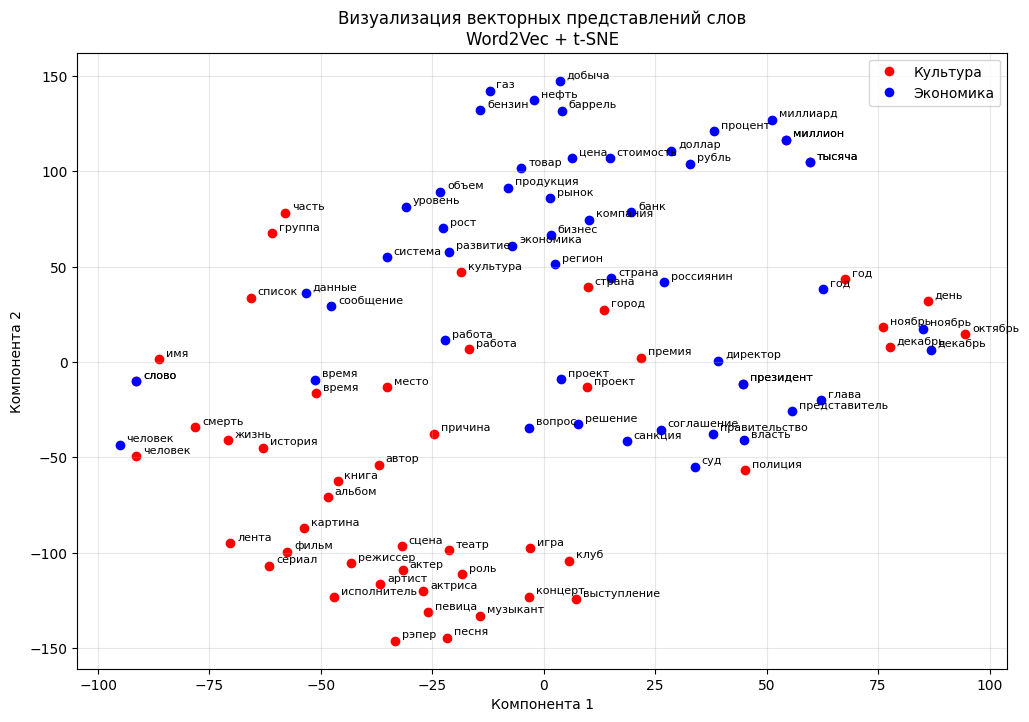


Анализ ближайших соседей:

Топ-5 слов для темы 'Культура':
год: ['полгода', 'месяц', 'десятилетие']
фильм: ['кинофильм', 'кино', 'сериал']
ноябрь: ['декабрь', 'октябрь', 'февраль']
концерт: ['концертный_ADJ', 'симфонический_ADJ', 'гала-концерт']
артист: ['актер', 'артистка', 'режиссер']

Топ-5 слов для темы 'Экономика':
год: ['полгода', 'месяц', 'десятилетие']
процент: ['процентный_ADJ', 'среднее', 'треть']
компания: ['фирма', 'holding', 'корпорация']
рубль: ['доллар', 'руб', 'копейка']
цена: ['стоимость', 'себестоимость', 'подорожать_VERB']


In [10]:
# Установка библиотеки gensim (если не установлена)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim import downloader
from collections import Counter
import re
from natasha import (
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    Doc
)

# Инициализация компонентов Natasha
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

def preprocess_text(text):
    """Лемматизация текста с выделением существительных"""
    if not isinstance(text, str):
        return []

    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    nouns = []
    for token in doc.tokens:
        if token.pos == 'NOUN':
            token.lemmatize(morph_vocab)
            lemma = token.lemma.lower()
            if len(lemma) > 2 and not re.match(r'[0-9]+', lemma):
                nouns.append(lemma)
    return nouns

df = pd.read_csv('../../labs/lenta_ru_news_filtered.csv')
df = df[df['topic'].isin(['Культура', 'Экономика'])]

culture_nouns = []
economy_nouns = []

for topic in ['Культура', 'Экономика']:
    topic_texts = df[df['topic'] == topic]['text'].head(500)  # Ограничиваем для скорости
    for text in topic_texts:
        if isinstance(text, str):
            nouns = preprocess_text(text)
            if topic == 'Культура':
                culture_nouns.extend(nouns)
            else:
                economy_nouns.extend(nouns)

culture_top = [word for word, count in Counter(culture_nouns).most_common(50)]
economy_top = [word for word, count in Counter(economy_nouns).most_common(50)]

print("Топ-50 существительных для Культуры:", culture_top[:10])
print("Топ-50 существительных для Экономики:", economy_top[:10])

print("Загрузка модели Word2Vec...")
kv = downloader.load('word2vec-ruscorpora-300')

culture_words = [f"{word}_NOUN" for word in culture_top if f"{word}_NOUN" in kv]
economy_words = [f"{word}_NOUN" for word in economy_top if f"{word}_NOUN" in kv]

print(f"Найдено в модели: {len(culture_words)} слов для Культуры, {len(economy_words)} для Экономики")

# Собираем векторы и метки
vectors = []
labels = []
words_list = []

for word in culture_words:
    vectors.append(kv[word])
    labels.append('Культура')
    words_list.append(word)

for word in economy_words:
    vectors.append(kv[word])
    labels.append('Экономика')
    words_list.append(word)

# Визуализация с помощью t-SNE
vectors = np.array(vectors)
tsne = TSNE(n_components=2, random_state=42, perplexity=min(10, len(vectors)-1))
vectors_2d = tsne.fit_transform(vectors)

plt.figure(figsize=(12, 8))
colors = {'Культура': 'red', 'Экономика': 'blue'}
for i, label in enumerate(labels):
    plt.scatter(vectors_2d[i, 0], vectors_2d[i, 1],
                c=colors[label], label=label if i == 0 else "")
    plt.annotate(words_list[i].replace('_NOUN', ''),
                (vectors_2d[i, 0], vectors_2d[i, 1]),
                xytext=(5, 2), textcoords='offset points', fontsize=8)

handles = [plt.Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=color, markersize=8)
           for color in colors.values()]
plt.legend(handles, colors.keys())

plt.title('Визуализация векторных представлений слов\nWord2Vec + t-SNE')
plt.xlabel('Компонента 1')
plt.ylabel('Компонента 2')
plt.grid(alpha=0.3)
plt.show()

print("\nАнализ ближайших соседей:")
for word_list, topic in zip([culture_words[:5], economy_words[:5]], ['Культура', 'Экономика']):
    print(f"\nТоп-5 слов для темы '{topic}':")
    for word in word_list:
        if word in kv:
            similar = kv.most_similar(word, topn=3)
            similar_words = [w[0].replace('_NOUN', '') for w in similar]
            print(f"{word.replace('_NOUN', '')}: {similar_words}")